# Research Question:
### What are the most influential variables on the severity of accidents?

Useful Paper:
    https://www.sciencedirect.com/science/article/pii/S2590198223000611

In [1]:
#Display Spark Output in scrollable format within jupyter notebook
from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

In [2]:
# Import Libraries
import pandas as pd
import numpy as np
import os
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.stat import Correlation
import seaborn as sns
import matplotlib.pyplot as plt
import pyspark.sql.functions as F
import holidays
from datetime import datetime, timezone

# Load Data

In [3]:
#Instantiate Spark Session
spark = (SparkSession
  .builder
  .appName("US_Accidents")
  .getOrCreate())

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/25 14:29:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
#Define Spark Schema
schema = StructType([StructField('ID', StringType(), False),
                StructField('Source', StringType(), False),
                StructField('Severity', IntegerType(), False),
                StructField('Start_Time', TimestampType(), False),                  
                StructField('End_Time', TimestampType(), False),      
                StructField('Start_Lat', DecimalType(), False),
                StructField('Start_Lng', DecimalType(), False),
                StructField('End_Lat', DecimalType(), True),
                StructField('End_Lng', DecimalType(), True),       
                StructField('Distance(mi)', DecimalType(), False),       
                StructField('Description', StringType(), False),       
                StructField('Street', StringType(), True),                 
                StructField('City', StringType(), True),       
                StructField('County', StringType(), True),       
                StructField('State', StringType(), True),       
                StructField('Zipcode', StringType(), True),       
                StructField('Country', StringType(), True),       
                StructField('Timezone', StringType(), True),       
                StructField('Airport_Code', StringType(), True),
                StructField('Weather_Timestamp', TimestampType(), True),
                StructField('Temperature(F)', DecimalType(), True),
                StructField('Wind_Chill(F)', DecimalType(), True),
                StructField('Humidity(%)', DecimalType(), True),
                StructField('Pressure(in)', DecimalType(), True),
                StructField('Visibility(mi)', DecimalType(), True),
                StructField('Wind_Direction', StringType(), True),
                StructField('Wind_Speed(mph)', DecimalType(), True),
                StructField('Precipitation(in)', DecimalType(), True),
                StructField('Weather_Condition', StringType(), True),
                StructField('Amenity', BooleanType(), False),
                StructField('Bump', BooleanType(), False),
                StructField('Crossing', BooleanType(), False),
                StructField('Give_way', BooleanType(), False),
                StructField('Junction', BooleanType(), False),
                StructField('No_Exit', BooleanType(), False),
                StructField('Railway', BooleanType(), False), 
                StructField('Roundabout', BooleanType(), False),
                StructField('Station', BooleanType(), False),
                StructField('Stop', BooleanType(), False),
                StructField('Traffic_Calming', BooleanType(), False),
                StructField('Traffic_Signal', BooleanType(), False),
                StructField('Turning_Loop', BooleanType(), False),
                StructField('Sunrise_Sunset', StringType(), True),
                StructField('Civil_Twilight', StringType(), True),
                StructField('Nautical_Twilight', StringType(), True),
                StructField('Astronomical_Twilight', StringType(), True)])

# Use the DataFrameReader interface to read a CSV file
file = "data/US_Accidents_March23.csv"
df = spark.read.csv(file, header=True, schema=schema)

In [5]:
# Get row count
rows = df.count()
print(f"DataFrame Rows count : {rows}")

# Get columns count
cols = len(df.columns)
print(f"DataFrame Columns count : {cols}")

DataFrame Rows count : 7728394
DataFrame Columns count : 46


# Nulls

In [6]:
#Null counts (excluding time columns)
df.agg(*[
    (rows-count(c)).alias(c) # column-wise operations in SQL ignore NULLs so returns count of null values
    for c in df.columns 
]).show()

24/11/25 14:29:59 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+---+------+--------+----------+--------+---------+---------+-------+-------+------------+-----------+------+----+------+-----+-------+-------+--------+------------+-----------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+----+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+
| ID|Source|Severity|Start_Time|End_Time|Start_Lat|Start_Lng|End_Lat|End_Lng|Distance(mi)|Description|Street|City|County|State|Zipcode|Country|Timezone|Airport_Code|Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Weather_Condition|Amenity|Bump|Crossing|Give_way|Junction|No_Exit|Railway|Roundabout|Station|Stop|Traffic_Calming|Traffic_Signal|Turning_Loop|Sunrise_Sunset|Civil_Twilight|Nautical_Twil

In [7]:
#have to remove the ~8000 rows with null timezone if using date/time in any way
df = df.dropna(subset=["Timezone"])
df.groupBy('Timezone').count().orderBy(desc("count")).show()

+-----------+-------+
|   Timezone|  count|
+-----------+-------+
| US/Eastern|3580167|
| US/Pacific|2062984|
| US/Central|1645616|
|US/Mountain| 431819|
+-----------+-------+



# Engineer Weather and Time Columns

In [8]:
# Create Day of the Week Column
df = df.withColumn('Day_of_Week', dayofweek(col('Start_Time'))) #Ranges from 1 for a Sunday through to 7 for a Saturday

# Create Weekday Column (1 = Weekday, 0 = Weekend)
df = df.withColumn(
    'Weekday',
    F.when(F.col("Day_of_Week").between(2, 6), 1)\
    .otherwise(0))

df.show(5)

+---+-------+--------+-------------------+-------------------+---------+---------+-------+-------+------------+--------------------+--------------------+------------+----------+-----+----------+-------+----------+------------+-------------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+-----------+-------+
| ID| Source|Severity|         Start_Time|           End_Time|Start_Lat|Start_Lng|End_Lat|End_Lng|Distance(mi)|         Description|              Street|        City|    County|State|   Zipcode|Country|  Timezone|Airport_Code|  Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Weather_Condition|Amenity| Bump|Cross

In [9]:
# Create Month Column
df = df.withColumn('Month', month(df['Start_Time']))
df.show(5)

+---+-------+--------+-------------------+-------------------+---------+---------+-------+-------+------------+--------------------+--------------------+------------+----------+-----+----------+-------+----------+------------+-------------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+-----------+-------+-----+
| ID| Source|Severity|         Start_Time|           End_Time|Start_Lat|Start_Lng|End_Lat|End_Lng|Distance(mi)|         Description|              Street|        City|    County|State|   Zipcode|Country|  Timezone|Airport_Code|  Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Weather_Condition|Amenity| Bump

In [10]:
# Create Season Column
df = df.withColumn(
    'Season',
    F.when(F.col("Month").between(3, 5), 'Spring')\
    .when(F.col("Month").between(6, 8), 'Summer')\
    .when(F.col("Month").between(9, 11), 'Fall')\
    .otherwise('Winter'))
df.show(5)

+---+-------+--------+-------------------+-------------------+---------+---------+-------+-------+------------+--------------------+--------------------+------------+----------+-----+----------+-------+----------+------------+-------------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+-----------+-------+-----+------+
| ID| Source|Severity|         Start_Time|           End_Time|Start_Lat|Start_Lng|End_Lat|End_Lng|Distance(mi)|         Description|              Street|        City|    County|State|   Zipcode|Country|  Timezone|Airport_Code|  Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Weather_Condition|Amenit

In [11]:
# Create Rush Hour Column
# defined as 6-9am and 4-7pm (https://www.goldlaw.com/how-deadly-is-rush-hour/)
df = df.withColumn('Start_Time_Time', date_format('Start_Time', 'HH:mm:ss'))
df.show(5)
df = df.withColumn(
    'Rush Hour',
    F.when(F.col('Start_Time_Time').between('06:00:00', '09:00:00'), 1)\
    .when(F.col('Start_Time_Time').between('16:00:00', '19:00:00'), 1)\
    .otherwise(0))
df.show(5)

+---+-------+--------+-------------------+-------------------+---------+---------+-------+-------+------------+--------------------+--------------------+------------+----------+-----+----------+-------+----------+------------+-------------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+-----------+-------+-----+------+---------------+
| ID| Source|Severity|         Start_Time|           End_Time|Start_Lat|Start_Lng|End_Lat|End_Lng|Distance(mi)|         Description|              Street|        City|    County|State|   Zipcode|Country|  Timezone|Airport_Code|  Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Weather_

In [12]:
# Create columns for rain and snow from weather_condition column

rain_values = ['Rain', 'Drizzle', 'Mist', 'N/A Precipitation']
snow_values = ['Ice', 'Snow', 'Hail', 'Sleet', 'Wintry Mix', 'Freezing Rain', 'Freezing Drizzle']

condition = F.when(F.col('Weather_Condition').rlike("|".join(rain_values)), 1).otherwise(0)
df = df.withColumn("Rain", condition)

condition = F.when(F.col('Weather_Condition').rlike("|".join(snow_values)), 1).otherwise(0)
df = df.withColumn("Snow", condition)

df.show(5)

+---+-------+--------+-------------------+-------------------+---------+---------+-------+-------+------------+--------------------+--------------------+------------+----------+-----+----------+-------+----------+------------+-------------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+-----------+-------+-----+------+---------------+---------+----+----+
| ID| Source|Severity|         Start_Time|           End_Time|Start_Lat|Start_Lng|End_Lat|End_Lng|Distance(mi)|         Description|              Street|        City|    County|State|   Zipcode|Country|  Timezone|Airport_Code|  Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precip

# Encoding Categorical Variables

In [13]:
# Encode Season

# StringIndexer
indexer = StringIndexer(inputCol="Season", outputCol="SeasonIndex")
indexed = indexer.fit(df).transform(df)

# OneHotEncoder
encoder = OneHotEncoder(inputCols=["SeasonIndex"], outputCols=["SeasonVec"])
df = encoder.fit(indexed).transform(indexed)

# Show the result
df.show(5)

+---+-------+--------+-------------------+-------------------+---------+---------+-------+-------+------------+--------------------+--------------------+------------+----------+-----+----------+-------+----------+------------+-------------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+-----------+-------+-----+------+---------------+---------+----+----+-----------+-------------+
| ID| Source|Severity|         Start_Time|           End_Time|Start_Lat|Start_Lng|End_Lat|End_Lng|Distance(mi)|         Description|              Street|        City|    County|State|   Zipcode|Country|  Timezone|Airport_Code|  Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direct

In [14]:
#Encode Day/Night to 1/0
for x in enumerate(['Sunrise_Sunset'
               , 'Civil_Twilight'
               , 'Nautical_Twilight'
               , 'Astronomical_Twilight']):
    # Create a StringIndexer instance
    indexer = StringIndexer(inputCol=x[1], outputCol=f"{x[1]}Index").setHandleInvalid("keep")

    # Fit the indexer to the data
    model = indexer.fit(df)

    # Transform the data to include the indexed column
    df = model.transform(df)
    
# Change Data Type 
for x in enumerate(['Sunrise_SunsetIndex'
               , 'Civil_TwilightIndex'
               , 'Nautical_TwilightIndex'
               , 'Astronomical_TwilightIndex']):
    df = df.withColumn(x[1], col(x[1]).cast("int"))
df.show(10)

+----+-------+--------+-------------------+-------------------+---------+---------+-------+-------+------------+--------------------+--------------------+------------+----------+-----+----------+-------+----------+------------+-------------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+-----------+-------+-----+------+---------------+---------+----+----+-----------+-------------+-------------------+-------------------+----------------------+--------------------------+
|  ID| Source|Severity|         Start_Time|           End_Time|Start_Lat|Start_Lng|End_Lat|End_Lng|Distance(mi)|         Description|              Street|        City|    County|State|   Zipcode|Country|  Timezone|Airport_Code|  Weathe

# Engineering Other Columns

In [15]:
pattern = r"(I-|Freeway|freeway|Interstate|interstate)"
df = df.withColumn("Interstate Indicator", F.when(F.col("Street").rlike(pattern), 1).otherwise(0)) #create the "Interstate Indicator" column

# Correlations

24/11/25 14:30:56 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


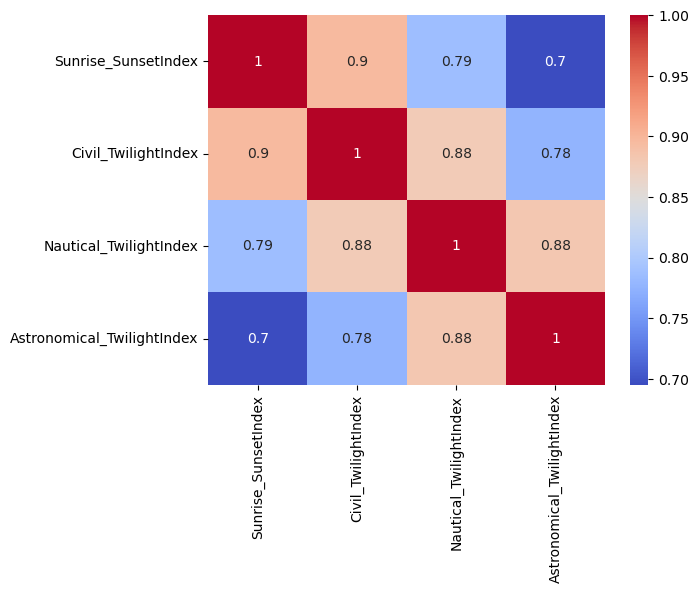

In [16]:
# Correlations - Day/Night Columns
# Select Relevant Columns
df1 = df.select('Sunrise_SunsetIndex'
               , 'Civil_TwilightIndex'
               , 'Nautical_TwilightIndex'
               , 'Astronomical_TwilightIndex')
df1 = df1.na.drop()

# Assemble features into a vector column
assembler = VectorAssembler(inputCols=['Sunrise_SunsetIndex'
               , 'Civil_TwilightIndex'
               , 'Nautical_TwilightIndex'
               , 'Astronomical_TwilightIndex'], outputCol="features")
df_vector = assembler.transform(df1)

# Calculate the correlation matrix
correlation_matrix = Correlation.corr(df_vector, "features").head()[0]

# Turn into a dataframe
corr_matrix_pd = pd.DataFrame(correlation_matrix.toArray(), columns=df1.columns, index=df1.columns)

#Plot
sns.heatmap(corr_matrix_pd, annot=True, cmap="coolwarm")
plt.show()

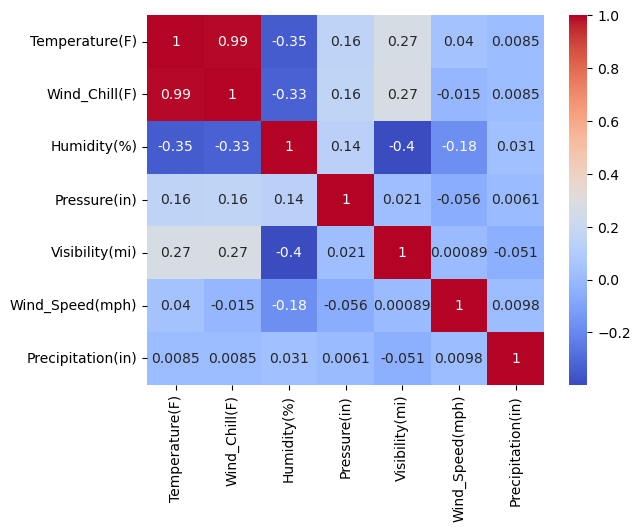

In [17]:
# Correlations - Weather Columns
# Select Relevant Columns
df1 = df.select('Temperature(F)'
               , 'Wind_Chill(F)'
               , 'Humidity(%)'
               , 'Pressure(in)'
               , 'Visibility(mi)'
               #, 'Wind_Direction'
               , 'Wind_Speed(mph)'
               , 'Precipitation(in)')
df1 = df1.na.drop()

# Assemble features into a vector column
assembler = VectorAssembler(inputCols=['Temperature(F)'
               , 'Wind_Chill(F)'
               , 'Humidity(%)'
               , 'Pressure(in)'
               , 'Visibility(mi)'
               #, 'Wind_Direction'
               , 'Wind_Speed(mph)'
               , 'Precipitation(in)'], outputCol="features")
df_vector = assembler.transform(df1)

# Calculate the correlation matrix
correlation_matrix = Correlation.corr(df_vector, "features").head()[0]

# Turn into a dataframe
corr_matrix_pd = pd.DataFrame(correlation_matrix.toArray(), columns=df1.columns, index=df1.columns)

#Plot
sns.heatmap(corr_matrix_pd, annot=True, cmap="coolwarm")
plt.show()

# Add Demographic Columns based on Zipcode

In [18]:
file = "data/median_income_subset.csv"
df_income = spark.read.csv(file, header=True, inferSchema=True)
df_income = df_income.withColumnRenamed("Estimate!!Households!!Median income (dollars)", "MedianIncome")
df_income = df_income.withColumnRenamed("Margin of Error!!Households!!Median income (dollars)", "MedianIncome_MarginOfError")
median_income_df= df_income.select("zip_code", "MedianIncome", "MedianIncome_MarginOfError")
median_income_df = median_income_df.withColumn(
    "zip_code",
    F.lpad(F.col("zip_code"), 5, '0')  # Pad with '0' to a total length of 5
)

In [19]:
# Define bounds for outliers
lower_bound = 10000
upper_bound = 230000
outliers_df = median_income_df.filter(
    (F.col("MedianIncome") < lower_bound) |
    (F.col("MedianIncome") > upper_bound)
)

# Show outliers
outliers_df.show()
##########Use the median_income_df ###########

+--------+------------+--------------------------+
|zip_code|MedianIncome|MedianIncome_MarginOfError|
+--------+------------+--------------------------+
|   00913|        6493|                      2064|
|   02468|      241190|                     18167|
|   06820|      232523|                     21420|
|   07046|      242083|                     39943|
|   07970|      243219|                    153219|
|   10546|      237708|                     36761|
|   10597|      237667|                     91547|
|   19319|      244097|                    160162|
|   21723|      231172|                    124625|
|   40997|        8219|                      5837|
|   41843|        9643|                      9051|
|   44503|        9583|                      1039|
|   60022|      248243|                     34164|
|   60029|      235000|                     52008|
|   63073|      244205|                    195057|
|   64147|        7784|                      3479|
|   70082|        9732|        

In [20]:
# Add code from Layla here
# Use the DataFrameReader interface to read a CSV file
file = "data/gender_age_subset.csv"
df_gender = spark.read.csv(file, header=True, inferSchema=True)
# Use the DataFrameReader interface to read a CSV file
file = "data/population_subset.csv"
df_population = spark.read.csv(file, header=True, inferSchema=True)

In [21]:
# Define a dictionary for renaming
new_column_names = {
    "Estimate!!SEX AND AGE!!Total population!!Sex ratio (males per 100 females)": "Sex ratio (males per 100 females)",
    "Percent!!SEX AND AGE!!Total population!!15 to 19 years": "Percent_Age_15-19",
    "Percent!!SEX AND AGE!!Total population!!20 to 24 years": "Percent_Age_20-24",
    "Percent!!SEX AND AGE!!Total population!!65 years and over": "Percent_Age_65_over",
    # Add more mappings as needed
}

# Start with the original DataFrame
gender_df = df_gender

gender_df = gender_df.withColumn(
    "zip_code",
    F.lpad(F.col("zip_code"), 5, '0')  # Pad with '0' to a total length of 5
)
# Rename columns
for old_name, new_name in new_column_names.items():
    gender_df = gender_df.withColumnRenamed(old_name, new_name)

# Show the renamed DataFrame
gender_df.show()

+--------+---------------------------------+-----------------+-----------------+-------------------+
|zip_code|Sex ratio (males per 100 females)|Percent_Age_15-19|Percent_Age_20-24|Percent_Age_65_over|
+--------+---------------------------------+-----------------+-----------------+-------------------+
|   00601|                             99.5|              6.6|              6.7|               18.2|
|   00602|                             96.0|              6.3|              6.8|               18.2|
|   00603|                             96.5|              6.6|              6.5|               21.1|
|   00606|                            100.3|              6.4|              7.4|               19.9|
|   00610|                             93.9|              6.4|              6.9|               20.0|
|   00612|                             89.3|              6.6|              6.5|               21.6|
|   00616|                             85.0|              6.3|              8.5|           

In [22]:
df_population = df_population.withColumn(
    "zip_code",
    F.lpad(F.col("zip_code"), 5, '0')  # Pad with '0' to a total length of 5
)
df_population = df_population.withColumn(
    "Urban_Ratio",
    F.round(
        F.when(F.col(" !!Total:") != 0, F.col(" !!Total:!!Urban") / F.col(" !!Total:")).otherwise(None), 
        4  # Number of decimal places
    )
)
df_population.show() 
#### Use Urban_Ratio column #####

+---+--------+---------+----------------+----------------+-----------+
|_c0|zip_code| !!Total:| !!Total:!!Urban| !!Total:!!Rural|Urban_Ratio|
+---+--------+---------+----------------+----------------+-----------+
|  1|   00601|    17242|            7899|            9343|     0.4581|
|  2|   00602|    37548|           37321|             227|      0.994|
|  3|   00603|    49804|           49678|             126|     0.9975|
|  4|   00606|     5009|               0|            5009|        0.0|
|  5|   00610|    25731|           21805|            3926|     0.8474|
|  6|   00611|     1671|               0|            1671|        0.0|
|  7|   00612|    62425|           57085|            5340|     0.9145|
|  8|   00616|     9828|            9363|             465|     0.9527|
|  9|   00617|    22541|           21364|            1177|     0.9478|
| 10|   00622|     7838|            6792|            1046|     0.8665|
| 11|   00623|    39320|           38452|             868|     0.9779|
| 12| 

24/11/25 14:31:20 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , zip_code,  !!Total:,  !!Total:!!Urban,  !!Total:!!Rural
 Schema: _c0, zip_code,  !!Total:,  !!Total:!!Urban,  !!Total:!!Rural
Expected: _c0 but found: 
CSV file: file:///sfs/gpfs/tardis/home/ejh2wy/spark_traffic_data/population_subset.csv


In [23]:
df = df.withColumn('zip_code_5', F.substring(df.Zipcode, 1, 5))
 
# Step 2: Join with gender_df on zip_code_5
joined_gender_df = df.join(gender_df, df.zip_code_5 == gender_df.zip_code, "left")
 
# Step 3: Select columns from joined_gender_df, keeping zip_code_5 and the needed columns from gender_df
joined_gender_df = joined_gender_df.select(
    df['*'],  # All columns from df
    gender_df['Sex ratio (males per 100 females)'],
    gender_df['Percent_Age_15-19'],
    gender_df['Percent_Age_20-24'],
    gender_df['Percent_Age_65_over']
)
 
# Step 4: Join with df_population on zip_code_5
final_joined_df = joined_gender_df.join(median_income_df, joined_gender_df.zip_code_5 == median_income_df.zip_code, "left")
 
# Step 5: Select desired columns, keeping only zip_code_5 and avoiding duplicate zip_code columns
final_joined_df = final_joined_df.select(
    joined_gender_df['*'],  # All columns from the previous joined DataFrame
    median_income_df['MedianIncome'],
    median_income_df['MedianIncome_MarginOfError']
)
 
# Step 6: Join with df_urban_population
result_final_df = final_joined_df.join(df_population, final_joined_df.zip_code_5 == df_population.zip_code, "left")
 
# Step 7: Final selection to keep only zip_code_5 and relevant columns
result_final_df = result_final_df.select(
    final_joined_df['*'],  # All columns from the previous joined DataFrame
    df_population['Urban_Ratio']  # Only the Urban_Ratio column
)
 
# Show the final result
result_final_df.show()

+----+-------+--------+-------------------+-------------------+---------+---------+-------+-------+------------+--------------------+--------------------+------------+----------+-----+----------+-------+----------+------------+-------------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+-----------+-------+-----+------+---------------+---------+----+----+-----------+-------------+-------------------+-------------------+----------------------+--------------------------+--------------------+----------+---------------------------------+-----------------+-----------------+-------------------+------------+--------------------------+-----------+
|  ID| Source|Severity|         Start_Time|           End_Tim

In [24]:
# Step 8: Convert added columns to float
result_final_df = result_final_df.select(
    *[F.col(col).cast("float").alias(col) if col in ['Sex ratio (males per 100 females)', 'Percent_Age_15-19', 'Percent_Age_20-24',
                                                       'Percent_Age_65_over', 'MedianIncome',
                                                       'MedianIncome_MarginOfError', 'Urban_Ratio']
      else F.col(col) for col in result_final_df.columns]
)
 
# Show the final result
result_final_df.show()

+----+-------+--------+-------------------+-------------------+---------+---------+-------+-------+------------+--------------------+--------------------+------------+----------+-----+----------+-------+----------+------------+-------------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+-----------+-------+-----+------+---------------+---------+----+----+-----------+-------------+-------------------+-------------------+----------------------+--------------------------+--------------------+----------+---------------------------------+-----------------+-----------------+-------------------+------------+--------------------------+-----------+
|  ID| Source|Severity|         Start_Time|           End_Tim

# Initial Column Removal

In [25]:
#List all columns
df = result_final_df
print(df.columns)

['ID', 'Source', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Description', 'Street', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone', 'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing', 'Give_way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight', 'Day_of_Week', 'Weekday', 'Month', 'Season', 'Start_Time_Time', 'Rush Hour', 'Rain', 'Snow', 'SeasonIndex', 'SeasonVec', 'Sunrise_SunsetIndex', 'Civil_TwilightIndex', 'Nautical_TwilightIndex', 'Astronomical_TwilightIndex', 'Interstate Indicator', 'zip_code_5', 'Sex ratio (males per 100 females)', 'Percent_Age_15-19', 'Percent_Age_20-24', 'Percent_A

In [26]:
# Initial Column Removal
df = df.drop(
            'ID'
             , 'Source' # Not useful?
             , 'Start_Time' # Used to calculate Rush Hour and Holiday Columns
             , 'End_Time'
             , 'Start_Lat'
             , 'Start_Lng'
             , 'End_Lat'
             , 'End_Lng'
             , 'Distance(mi)' # Data leakage issue - captured after accident occured
             , 'Description' # Captures little new data
             , 'Street' # Not useful for prediction
             , 'City'
             , 'County'
             , 'State'
             , 'Zipcode'
             , 'Country' # 100% US
             , 'Timezone' # Not for prediction
             , 'Airport_Code' # Not for prediction
             , 'Weather_Timestamp' # Not for prediction
             , 'Wind_Chill(F)' # 99% correlated with Temperature(F)
             , 'Wind_Direction' # Not useful?
             , 'Weather_Condition' # Turning into binary columns for rain and snow
             , 'Turning_Loop' # 100% False (not a single true value)
             , 'Sunrise_Sunset' # Highly correlated with other day/night variables
             , 'Civil_Twilight' # Highly correlated with other day/night variables
             , 'Nautical_Twilight' # Highly correlated with other day/night variables
             , 'Astronomical_Twilight' # True Night - removing to keep index column
             , 'Day_of_Week' # Used to create Weekday column
             , 'Month' # Use Season instead
             , 'Season' #Used to create SeasonVec
             , 'Start_Time_Time' #Used to calculate Rush Hour Column
             , 'Start_Date_Date' #Used to calculate Holiday Column
             , 'Sunrise_SunsetIndex' # Highly correlated with other day/night variables
             , 'Civil_TwilightIndex' # Highly correlated with other day/night variables
             , 'Nautical_TwilightIndex' # Highly correlated with other day/night variables
             , 'SeasonIndex'
             , 'zip_code_5'
            )
df.show(5)

+--------+--------------+-----------+------------+--------------+---------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+-------+---------+----+----+-------------+--------------------------+--------------------+---------------------------------+-----------------+-----------------+-------------------+------------+--------------------------+-----------+
|Severity|Temperature(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Speed(mph)|Precipitation(in)|Amenity| Bump|Crossing|Give_way|Junction|No_Exit|Railway|Roundabout|Station| Stop|Traffic_Calming|Traffic_Signal|Weekday|Rush Hour|Rain|Snow|    SeasonVec|Astronomical_TwilightIndex|Interstate Indicator|Sex ratio (males per 100 females)|Percent_Age_15-19|Percent_Age_20-24|Percent_Age_65_over|MedianIncome|MedianIncome_MarginOfError|Urban_Ratio|
+--------+--------------+-----------+------------+--------------+---------------+-----------------+-------+---

# Further Column Removal and Preprocessing

### Nulls

In [27]:
rows = df.count()
print(rows)

#Null counts
df.agg(*[
    (rows-count(c)).alias(c)    # vertical (column-wise) operations in SQL ignore NULLs
    for c in df.columns 
]).show()

7720586


+--------+--------------+-----------+------------+--------------+---------------+-----------------+-------+----+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+-------+---------+----+----+---------+--------------------------+--------------------+---------------------------------+-----------------+-----------------+-------------------+------------+--------------------------+-----------+
|Severity|Temperature(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Speed(mph)|Precipitation(in)|Amenity|Bump|Crossing|Give_way|Junction|No_Exit|Railway|Roundabout|Station|Stop|Traffic_Calming|Traffic_Signal|Weekday|Rush Hour|Rain|Snow|SeasonVec|Astronomical_TwilightIndex|Interstate Indicator|Sex ratio (males per 100 females)|Percent_Age_15-19|Percent_Age_20-24|Percent_Age_65_over|MedianIncome|MedianIncome_MarginOfError|Urban_Ratio|
+--------+--------------+-----------+------------+--------------+---------------+-----------------+-------+----+--------+-

In [28]:
# Impute with 0 in 'Precipitation(in)' if 'Rain'=0 AND 'Snow'=0
df = df.withColumn("Precipitation(in)", when((col("Rain")==0) & (col("Snow")==0), 0).otherwise(col("Precipitation(in)")))

In [29]:
#Null counts check for Precipitation
df.agg(*[
    (rows-count('Precipitation(in)')).alias('Precipitation(in)')
]).show()

+-----------------+
|Precipitation(in)|
+-----------------+
|            38354|
+-----------------+



In [30]:
# Remove Nulls
df = df.dropna()
rows = df.count()
print(rows)
df.show(5)

7026946
+--------+--------------+-----------+------------+--------------+---------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+-------+---------+----+----+-------------+--------------------------+--------------------+---------------------------------+-----------------+-----------------+-------------------+------------+--------------------------+-----------+
|Severity|Temperature(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Speed(mph)|Precipitation(in)|Amenity| Bump|Crossing|Give_way|Junction|No_Exit|Railway|Roundabout|Station| Stop|Traffic_Calming|Traffic_Signal|Weekday|Rush Hour|Rain|Snow|    SeasonVec|Astronomical_TwilightIndex|Interstate Indicator|Sex ratio (males per 100 females)|Percent_Age_15-19|Percent_Age_20-24|Percent_Age_65_over|MedianIncome|MedianIncome_MarginOfError|Urban_Ratio|
+--------+--------------+-----------+------------+--------------+---------------+-----------------+---

### Too few data points (POIs)

In [31]:
from pyspark.sql.functions import sum
df.select(((sum(df.Amenity.cast("long"))/rows)*100).alias('Amenity % True'), 
          ((sum(df.Bump.cast("long"))/rows)*100).alias('Bump % True'),
          ((sum(df.Crossing.cast("long"))/rows)*100).alias('Crossing % True'), 
          ((sum(df.Give_way.cast("long"))/rows)*100).alias('Give Way % True'),
          ((sum(df.Junction.cast("long"))/rows)*100).alias('Junction % True'), 
          ((sum(df.No_Exit.cast("long"))/rows)*100).alias('No Exit % True'),
          ((sum(df.Railway.cast("long"))/rows)*100).alias('Railway % True'), 
          ((sum(df.Roundabout.cast("long"))/rows)*100).alias('Roundabout % True'),
          ((sum(df.Station.cast("long"))/rows)*100).alias('Station % True'), 
          ((sum(df.Stop.cast("long"))/rows)*100).alias('Stop % True'),
          ((sum(df.Traffic_Calming.cast("long"))/rows)*100).alias('Traffic Calming % True'), 
          ((sum(df.Traffic_Signal.cast("long"))/rows)*100).alias('Traffic Signal % True')
    ).show()

+-----------------+-------------------+------------------+------------------+-----------------+------------------+------------------+--------------------+------------------+------------------+----------------------+---------------------+
|   Amenity % True|        Bump % True|   Crossing % True|   Give Way % True|  Junction % True|    No Exit % True|    Railway % True|   Roundabout % True|    Station % True|       Stop % True|Traffic Calming % True|Traffic Signal % True|
+-----------------+-------------------+------------------+------------------+-----------------+------------------+------------------+--------------------+------------------+------------------+----------------------+---------------------+
|1.246131676549101|0.04669169223728203|11.457139417322972|0.4639853501079986|7.312650474331239|0.2575941241045541|0.8586802858596039|0.003315807464579...|2.6502978676654125|2.7679307625247156|    0.0993888383374513|   14.763796391775315|
+-----------------+-------------------+---------

### Outliers

In [32]:
def outliers(df, col):
    
    # Calculate quantiles
    q1, q3 = df.approxQuantile(col, [0.25, 0.75], 0.01) #arguably not quartiles anymore but changed to only pick up more extreme outliers
    iqr = q3 - q1

    # Define outlier boundaries
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Identify outliers
    outliers = df.filter((df[col] < lower_bound) | (df[col] > upper_bound))

    #outliers_df[col] = outliers
    outliers.select(col).sort(desc(col)).show()

In [33]:
col = 'Temperature(F)'
 #'Humidity(%)',
 #'Pressure(in)',
 #'Visibility(mi)',
 #'Wind_Speed(mph)',
 #'Precipitation(in)'

out = outliers(df, col)
print(out)

+--------------+
|Temperature(F)|
+--------------+
|           196|
|           196|
|           196|
|           196|
|           196|
|           189|
|           174|
|           174|
|           172|
|           172|
|           171|
|           169|
|           167|
|           162|
|           162|
|           162|
|           144|
|           140|
|           140|
|           140|
+--------------+
only showing top 20 rows

None


### Correlation between Features and Target

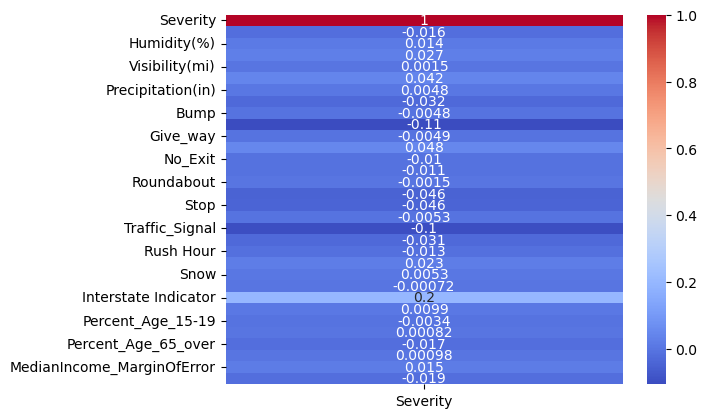

In [34]:
# Correlations - Day/Night Columns

cols = ['Severity', 
 'Temperature(F)',
 'Humidity(%)',
 'Pressure(in)',
 'Visibility(mi)',
 'Wind_Speed(mph)',
 'Precipitation(in)',
 'Amenity',
 'Bump',
 'Crossing',
 'Give_way',
 'Junction',
 'No_Exit',
 'Railway',
 'Roundabout',
 'Station',
 'Stop',
 'Traffic_Calming',
 'Traffic_Signal',
 'Weekday',
 'Rush Hour',
 #'Holiday',
 'Rain',
 'Snow',
 'Astronomical_TwilightIndex',
'Interstate Indicator',
 'Sex ratio (males per 100 females)',
 'Percent_Age_15-19',
 'Percent_Age_20-24',
 'Percent_Age_65_over',
 'MedianIncome',
 'MedianIncome_MarginOfError',
 'Urban_Ratio']
        
# Select Relevant Columns
df1 = df.select(cols)
df1 = df1.na.drop()

# Assemble features into a vector column
assembler = VectorAssembler(inputCols=cols, outputCol="features")
df_vector = assembler.transform(df1)

# Calculate the correlation matrix
correlation_matrix = Correlation.corr(df_vector, "features").head()[0]

# Turn into a dataframe
corr_matrix_pd = pd.DataFrame(correlation_matrix.toArray(), columns=df1.columns, index=df1.columns)
corr_matrix_pd = corr_matrix_pd.drop(['Temperature(F)',
 'Humidity(%)',
 'Pressure(in)',
 'Visibility(mi)',
 'Wind_Speed(mph)',
 'Precipitation(in)',
 'Amenity',
 'Bump',
 'Crossing',
 'Give_way',
 'Junction',
 'No_Exit',
 'Railway',
 'Roundabout',
 'Station',
 'Stop',
 'Traffic_Calming',
 'Traffic_Signal',
 'Weekday',
 'Rush Hour',
 #'Holiday',
 'Rain',
 'Snow',
 'Astronomical_TwilightIndex',
 'Interstate Indicator',
 'Sex ratio (males per 100 females)',
 'Percent_Age_15-19',
 'Percent_Age_20-24',
 'Percent_Age_65_over',
 'MedianIncome',
 'MedianIncome_MarginOfError',
 'Urban_Ratio'])

#Plot
ax = sns.heatmap(corr_matrix_pd.T, annot=True, cmap="coolwarm")
# Rotate the value labels by 90 degrees
#for t in ax.texts:
    #t.set_rotation(90)
plt.show()

In [35]:
df.show(5)

+--------+--------------+-----------+------------+--------------+---------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+-------+---------+----+----+-------------+--------------------------+--------------------+---------------------------------+-----------------+-----------------+-------------------+------------+--------------------------+-----------+
|Severity|Temperature(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Speed(mph)|Precipitation(in)|Amenity| Bump|Crossing|Give_way|Junction|No_Exit|Railway|Roundabout|Station| Stop|Traffic_Calming|Traffic_Signal|Weekday|Rush Hour|Rain|Snow|    SeasonVec|Astronomical_TwilightIndex|Interstate Indicator|Sex ratio (males per 100 females)|Percent_Age_15-19|Percent_Age_20-24|Percent_Age_65_over|MedianIncome|MedianIncome_MarginOfError|Urban_Ratio|
+--------+--------------+-----------+------------+--------------+---------------+-----------------+-------+---

### Combine Similar, Sparse Binary Columns

In [36]:
# Combine POIs
# Traffic interference, intersection, destination
columns_to_binary = ["Amenity", "Bump", "Crossing", "Give_Way", "Junction", "No_Exit", "Railway", 
                     "Roundabout", "Station", "Stop", "Traffic_Calming", "Traffic_Signal"]

for col in columns_to_binary:
    df = df.withColumn(col, F.col(col).cast(IntegerType()))

df = df.withColumn(
    "Traffic_Interference",
    F.when((F.col("Bump") + F.col("Railway") + F.col("Traffic_calming")) > 1, 1).otherwise(
        F.col("Bump") + F.col("Railway") + F.col("Traffic_calming")
    )
)

df = df.withColumn(
    "Traffic_Intersection",
    F.when((F.col("Crossing") + F.col("Give_way") + F.col("Junction") + F.col("Roundabout") + F.col("Stop") + F.col("Traffic_signal")) > 1, 1).otherwise(
        (F.col("Crossing") + F.col("Give_way") + F.col("Junction") + F.col("Roundabout") + F.col("Stop") + F.col("Traffic_signal"))
    )
)

df = df.withColumn(
    "Destination",
    F.when((F.col("Amenity") + F.col("Station")) > 1, 1).otherwise(
        (F.col("Amenity") + F.col("Station"))
    )
)

In [37]:
# Check Sparsity now
df.select(((sum(df.Traffic_Interference)/rows)*100).alias('Traffic_Interference % True'), 
          ((sum(df.Traffic_Intersection)/rows)*100).alias('Traffic_Intersection % True'),
          ((sum(df.Destination)/rows)*100).alias('Destination % True')
    ).show()

+---------------------------+---------------------------+------------------+
|Traffic_Interference % True|Traffic_Intersection % True|Destination % True|
+---------------------------+---------------------------+------------------+
|         0.9555929417986134|          28.18081994653154|3.5977222537358333|
+---------------------------+---------------------------+------------------+



In [38]:
#Remove combined POIs
df = df.drop('Amenity',
 'Bump',
 'Crossing',
 'Give_Way',
 'Junction',
 'No_Exit',
 'Railway', 
 'Roundabout',
 'Station',
 'Stop',
 'Traffic_Calming',
 'Traffic_Signal')
df.show(5)

+--------+--------------+-----------+------------+--------------+---------------+-----------------+-------+---------+----+----+-------------+--------------------------+--------------------+---------------------------------+-----------------+-----------------+-------------------+------------+--------------------------+-----------+--------------------+--------------------+-----------+
|Severity|Temperature(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Speed(mph)|Precipitation(in)|Weekday|Rush Hour|Rain|Snow|    SeasonVec|Astronomical_TwilightIndex|Interstate Indicator|Sex ratio (males per 100 females)|Percent_Age_15-19|Percent_Age_20-24|Percent_Age_65_over|MedianIncome|MedianIncome_MarginOfError|Urban_Ratio|Traffic_Interference|Traffic_Intersection|Destination|
+--------+--------------+-----------+------------+--------------+---------------+-----------------+-------+---------+----+----+-------------+--------------------------+--------------------+---------------------------------+-----

### Remove Nonsensical Outliers

In [39]:
# Remove outliers that are almost guaranteed to be data collection errors
df = df.filter(F.col("Wind_Speed(mph)") <= 318)
df = df.filter(F.col("Pressure(in)") <= 31.42)
df = df.filter(F.col("Temperature(F)") <= 130)

# Force all "Visibility(mi)" values over 40 to be 40 to retain data but not have extremely influential outliers
df = df.withColumn("Visibility(mi)", F.when(F.col("Visibility(mi)") > 40, 40).otherwise(F.col("Visibility(mi)")))

### Look into Margin of Error for Median Income

In [40]:
df.select('MedianIncome').where(df.MedianIncome_MarginOfError/df.MedianIncome > 0.5).count()

42343

# Create Binary Target Column

In [41]:
# Check Class Imbalance
cts = df.groupBy("Severity").count().withColumn('percent', (F.col('count') / rows)*100)
cts.show()

+--------+-------+------------------+
|Severity|  count|           percent|
+--------+-------+------------------+
|       1|  65142|0.9270314586165882|
|       3|1123799| 15.99270863900192|
|       4| 178821| 2.544789727998479|
|       2|5659044| 80.53347784371759|
+--------+-------+------------------+



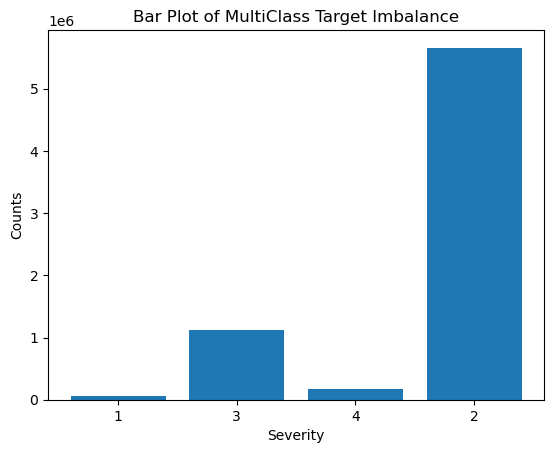

In [42]:
# Plot Class Imbalance
cts = cts.toPandas()
cts['Severity'] = cts['Severity'].astype(str)
plt.bar(cts.Severity, cts['count'])
plt.xlabel('Severity')
plt.ylabel('Counts')
plt.title('Bar Plot of MultiClass Target Imbalance')
plt.show()

In [44]:
# Add Severity Binary Column
df = df.withColumn('Severity_Binary', when((F.col("Severity")==1) | (F.col("Severity")==2), 0).otherwise(1))

In [45]:
# Check Class Imbalance
cts = df.groupBy("Severity_Binary").count().withColumn('percent', (F.col('count') / rows)*100)
cts.show()

+---------------+-------+------------------+
|Severity_Binary|  count|           percent|
+---------------+-------+------------------+
|              1|1302620|18.537498367000403|
|              0|5724186| 81.46050930233419|
+---------------+-------+------------------+



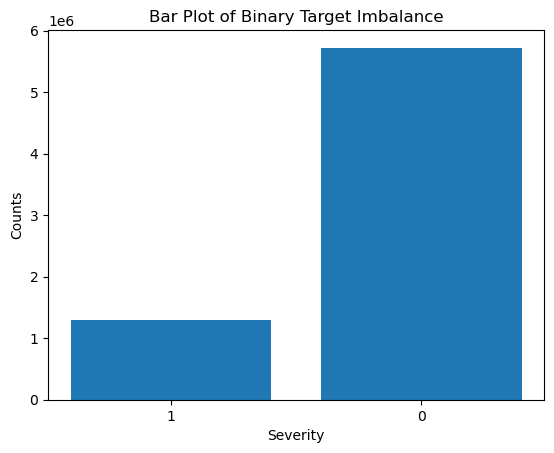

In [46]:
# Plot Class Imbalance
cts = cts.toPandas()
cts['Severity_Binary'] = cts['Severity_Binary'].astype(str)
plt.bar(cts.Severity_Binary, cts['count'])
plt.xlabel('Severity')
plt.ylabel('Counts')
plt.title('Bar Plot of Binary Target Imbalance')
plt.show()

# Final Data Frame

In [47]:
# Rename Columns
df = df.withColumnRenamed("Temperature(F)", "Temperature")
df = df.withColumnRenamed("Humidity(%)", "Humidity")
df = df.withColumnRenamed("Pressure(in)", "Pressure")
df = df.withColumnRenamed("Visibility(mi)", "Visibility")
df = df.withColumnRenamed("Wind_Speed(mph)", "Wind_Speed")
df = df.withColumnRenamed("Precipitation(in)", "Precipitation")
df = df.withColumnRenamed("Rush Hour", "Rush_Hour")
df = df.withColumnRenamed("Interstate Indicator", "Interstate_Indicator")
df = df.withColumnRenamed("Sex ratio (males per 100 females)", "Sex_ratio")

# Remove MedianIncome_MarginOfError
df = df.drop('MedianIncome_MarginOfError')

#Drop multiclass severity column
df = df.drop('Severity')

#Show
df.show(10)

+-----------+--------+--------+----------+----------+-------------+-------+---------+----+----+-------------+--------------------------+--------------------+---------+-----------------+-----------------+-------------------+------------+-----------+--------------------+--------------------+-----------+---------------+
|Temperature|Humidity|Pressure|Visibility|Wind_Speed|Precipitation|Weekday|Rush_Hour|Rain|Snow|    SeasonVec|Astronomical_TwilightIndex|Interstate_Indicator|Sex_ratio|Percent_Age_15-19|Percent_Age_20-24|Percent_Age_65_over|MedianIncome|Urban_Ratio|Traffic_Interference|Traffic_Intersection|Destination|Severity_Binary|
+-----------+--------+--------+----------+----------+-------------+-------+---------+----+----+-------------+--------------------------+--------------------+---------+-----------------+-----------------+-------------------+------------+-----------+--------------------+--------------------+-----------+---------------+
|         36|     100|      30|        10| 

In [48]:
# Get row count
rows = df.count()
print(f"DataFrame Rows count : {rows}")

# Get columns count
cols = len(df.columns)
print(f"DataFrame Columns count : {cols}")

DataFrame Rows count : 7026806
DataFrame Columns count : 23


# Check for Multicollinearity

In [49]:
# Select all features except target variable
feature_list = []
for col in df.columns:
    if col == 'Severity_Binary':
        continue
    else:
        feature_list.append(col)      
        
# Vectorize Features
assembler = VectorAssembler(inputCols=feature_list, outputCol='features')

In [51]:
feature_list = ['Temperature',
 'Humidity',
 'Pressure',
 'Visibility',
 'Wind_Speed',
 'Precipitation',
 'Weekday',
 'Rush_Hour',
 'Rain',
 'Snow',
 'SeasonVec',
 'SeasonVec1',
 'SeasonnVec2',
 'Astronomical_TwilightIndex',
 'Interstate_Indicator',
 'Sex_ratio',
 'Percent_Age_65_over',
 'MedianIncome',
 'Urban_Ratio',
 'Traffic_Interference',
 'Traffic_Intersection',
 'Destination',
 'Percent_Age_15-19',
 'Percent_Age_20-24']

In [52]:
# Assemble features into a vector
df_vector = assembler.transform(df)

# Calculate the correlation matrix
correlation_matrix = Correlation.corr(df_vector, "features").head()[0]

# Turn into a dataframe
corr_matrix_pd = pd.DataFrame(correlation_matrix.toArray(), columns=feature_list, index=feature_list)

# Get the pairs of columns with correlation greater than 0.5
high_corr_pairs = []
for col1 in corr_matrix_pd.columns:
    for col2 in corr_matrix_pd.columns:
        if col1 != col2 and ((corr_matrix_pd[col1][col2] > 0.4) | (corr_matrix_pd[col1][col2] < -0.4)):
            high_corr_pairs.append((col1, col2, corr_matrix_pd[col1][col2]))

print(high_corr_pairs)

[('Temperature', 'SeasonVec', -0.517578216843998), ('SeasonVec', 'Temperature', -0.517578216843998), ('Percent_Age_65_over', 'MedianIncome', 0.46583032647448935), ('MedianIncome', 'Percent_Age_65_over', 0.46583032647448935), ('MedianIncome', 'Urban_Ratio', -0.4000733034075923), ('Urban_Ratio', 'MedianIncome', -0.4000733034075923)]


### Combine younger age columns

In [53]:
# Combine Columns Percent_Age_15-19 and Percent_Age_20-24
df = df.withColumn(
    'Percent_Age_15-24',
    F.col('Percent_Age_15-19') + F.col('Percent_Age_20-24')
)

df = df.drop('Percent_Age_15-19')
df = df.drop('Percent_Age_20-24')

# Save Final Dataset

In [54]:
#Write to parquet
df.write.parquet("final_dataset_binary.parquet")

24/11/25 14:40:40 WARN MemoryManager: Total allocation exceeds 95.00% (982,699,200 bytes) of heap memory
Scaling row group sizes to 91.52% for 8 writers
24/11/25 14:40:52 WARN MemoryManager: Total allocation exceeds 95.00% (982,699,200 bytes) of heap memory
Scaling row group sizes to 91.52% for 8 writers
24/11/25 14:40:53 WARN MemoryManager: Total allocation exceeds 95.00% (982,699,200 bytes) of heap memory
Scaling row group sizes to 91.52% for 8 writers
24/11/25 14:40:53 WARN MemoryManager: Total allocation exceeds 95.00% (982,699,200 bytes) of heap memory
Scaling row group sizes to 91.52% for 8 writers
24/11/25 14:40:53 WARN MemoryManager: Total allocation exceeds 95.00% (982,699,200 bytes) of heap memory
Scaling row group sizes to 91.52% for 8 writers
24/11/25 14:40:59 WARN MemoryManager: Total allocation exceeds 95.00% (982,699,200 bytes) of heap memory
Scaling row group sizes to 91.52% for 8 writers
24/11/25 14:40:59 WARN MemoryManager: Total allocation exceeds 95.00% (982,699,200